In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/potato1/QVI_purchase_behaviour.csv
/kaggle/input/potato1/QVI_transaction_data.csv
/kaggle/input/potato1/QVI_transaction_data.xlsx


# Data Analysis of Potato Chips Purchase Behavior

## Dataset Overview

Transaction data (QVI_transaction_data.xlsx): Contains detailed purchase information including:

* Date of purchase
* Store number
* Loyalty card number
* Transaction ID
* Product details (number, name, quantity)
* Total sales amount

Customer behavior data (QVI_purchase_behaviour.csv): Contains customer segmentation information linking loyalty card numbers to:
* Life stage categories
* Premium customer status (Budget, Mainstream, Premium)

In [2]:
# Load and perform initial cleaning of the data

# Load transaction data
transaction_data = pd.read_excel('../input/potato1/QVI_transaction_data.xlsx')

In [3]:
 # Load customer behavior data
customer_data = pd.read_csv('../input/potato1/QVI_purchase_behaviour.csv')

In [4]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [6]:
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


## Data Cleaning 

In [7]:
# Convert Excel numeric date to datetime
transaction_data['DATE'] = pd.to_datetime(
    transaction_data['DATE'], unit='D', origin='1899-12-30')

In [8]:
#%% Clean product names
# Remove salsa products
transaction_data = transaction_data[
    ~transaction_data['PROD_NAME'].str.lower().str.contains('salsa')]


## Handling Outliers

Those big purchases might be from commercial buyers, not regular customers, so removing them helps focus on
typical consumer behavior.

In [9]:
#%% Handle outliers
# Check quantity outliers
print("\nProduct quantity summary:")
print(transaction_data['PROD_QTY'].describe())


Product quantity summary:
count    246742.000000
mean          1.908062
std           0.659831
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64


In [10]:
# Find transactions with 200 packets
outlier_transactions = transaction_data[transaction_data['PROD_QTY'] == 200]
print("\nOutlier transactions:")
print(outlier_transactions)


Outlier transactions:
            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


In [11]:
# Remove outlier customer
loyalty_outlier = outlier_transactions['LYLTY_CARD_NBR'].unique()
transaction_data = transaction_data[
    ~transaction_data['LYLTY_CARD_NBR'].isin(loyalty_outlier)]

## Feature Engineering

Extracting pack size and cleaning brand names. Merging transaction data with customer data allowed them to analyze by customer segments.

In [12]:
#%% Feature engineering
# Extract pack size
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)').astype(float)


In [13]:
# Create brand name (first word in product name)
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

In [14]:
# Clean brand names
transaction_data['BRAND'] = transaction_data['BRAND'].replace({
    'Red': 'Red Rock Deli',
    'RRD': 'Red Rock Deli',
    'Snbts': 'Sunbites',
    'GrnWves': 'Grain Waves',
    'Infzns': 'Infuzions',
    'Dorito': 'Doritos',
    'Grain': 'Grain Waves',
    'WW': 'Woolworths',

})


In [15]:
#%% Merge customer data
merged_data = pd.merge(transaction_data, customer_data, 
                      on='LYLTY_CARD_NBR', how='left')

In [16]:
# Check for missing customers
print("\nMissing customer data count:", merged_data['LIFESTAGE'].isna().sum())



Missing customer data count: 0


# Key Insights from Customer Segment Analysis

## Total Sales Contribution

Looking at the total sales by segment, the highest sales come from Mainstream - young singles/couples and Mainstream retirees. Budget older families also contribute significantly.

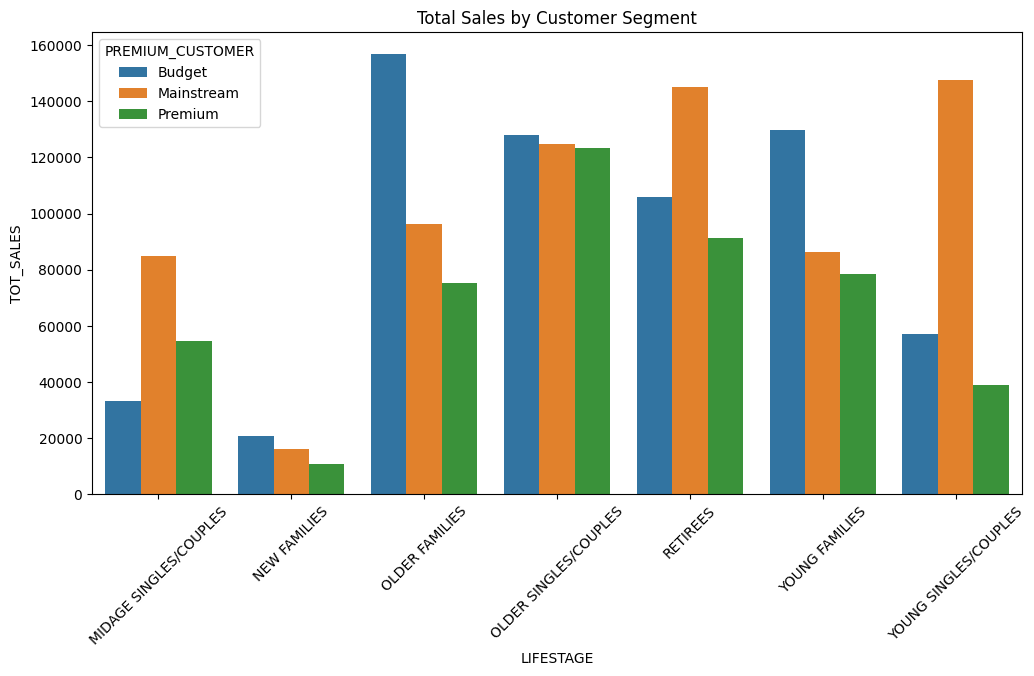

In [17]:
#%% Customer segment analysis
# Total sales by segment
total_sales = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()


plt.figure(figsize=(12,6))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=total_sales)
plt.title('Total Sales by Customer Segment')
plt.xticks(rotation=45)
plt.show()


## Customer Count Distribution

* Largest customer segment: YOUNG SINGLES/COUPLES
* Strong representation in the Mainstream category across most life stages
* RETIREES show a more even distribution across Premium segments

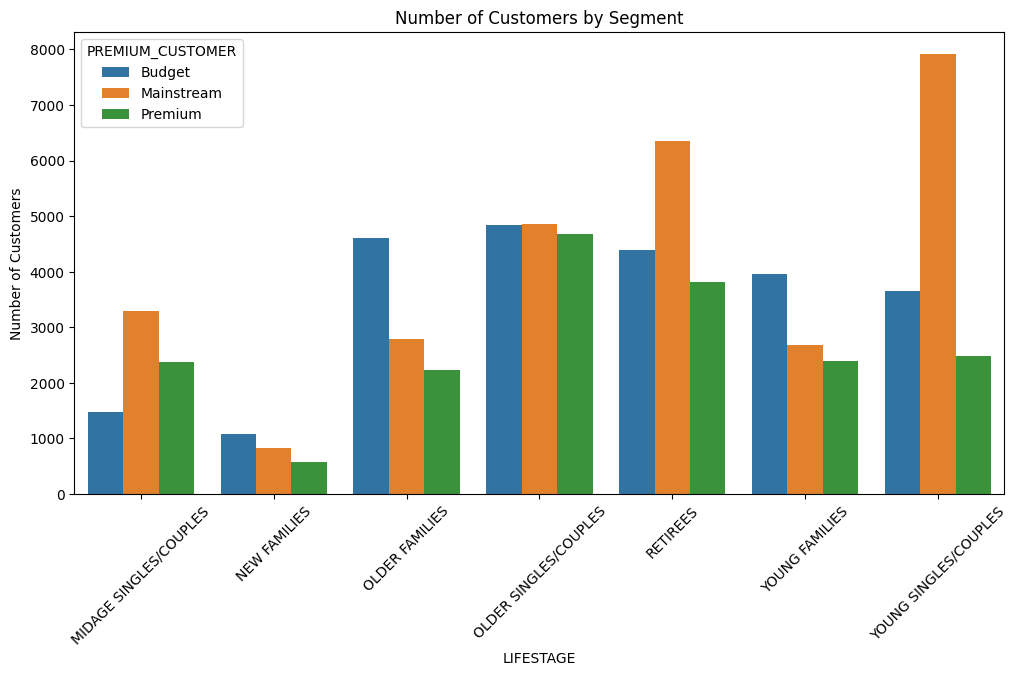

In [18]:
# Number of customers by segment
customer_count = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='LIFESTAGE', y='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER', data=customer_count)
plt.title('Number of Customers by Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

## Units per Customer

* OLDER FAMILIES and YOUNG FAMILIES buy more units per customer
* Mainstream customers generally purchase more units compared to Budget customers

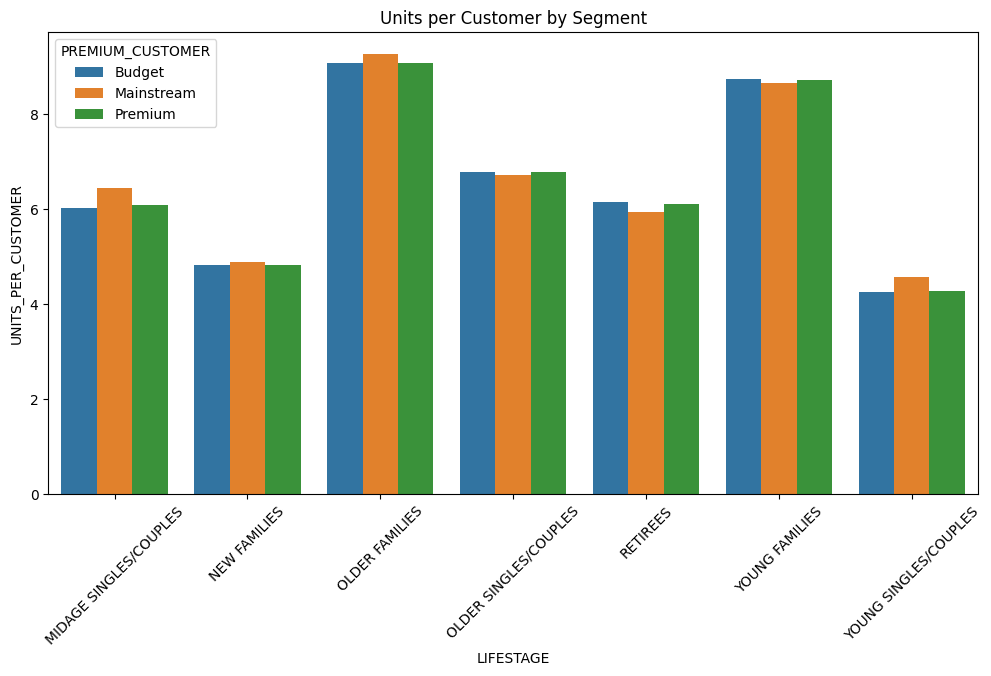

In [19]:
# Units per customer
units_by_customer = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({
    'PROD_QTY': 'sum',
    'LYLTY_CARD_NBR': 'nunique'
}).reset_index()
units_by_customer['UNITS_PER_CUSTOMER'] = units_by_customer['PROD_QTY'] / units_by_customer['LYLTY_CARD_NBR']


# Plot units per customer
plt.figure(figsize=(12,6))
sns.barplot(data=units_by_customer, x='LIFESTAGE', y='UNITS_PER_CUSTOMER', hue='PREMIUM_CUSTOMER')
plt.title('Units per Customer by Segment')
plt.xticks(rotation=45)
plt.show()

 ## Price Sensitivity

Price per unit analysis shows Mainstream midage and young singles/couples pay more on average.

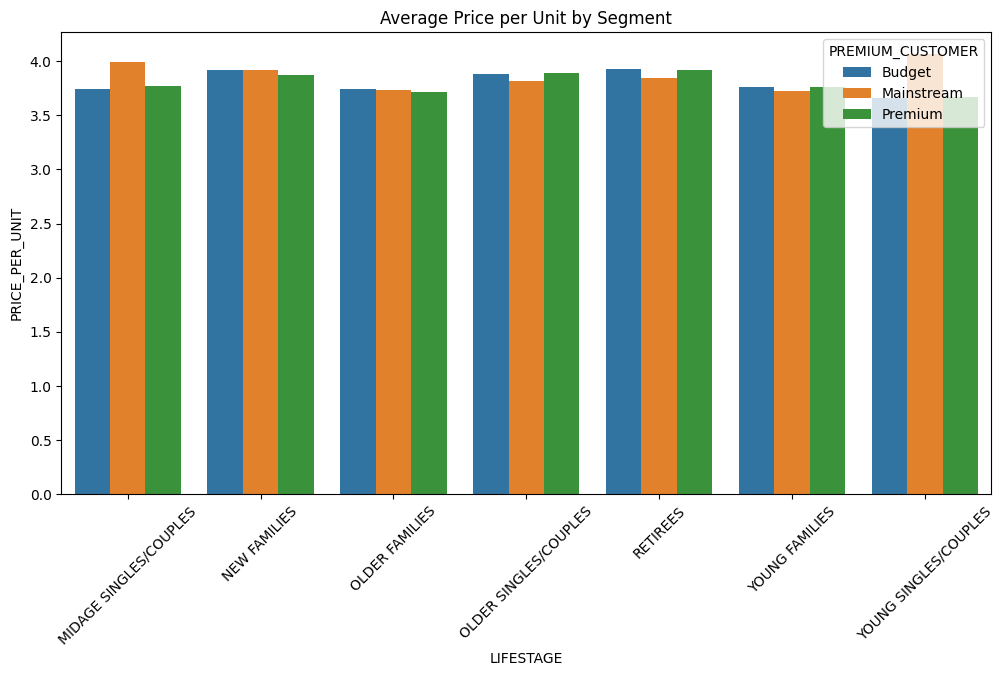

In [20]:
# Average price per unit
merged_data['PRICE_PER_UNIT'] = merged_data['TOT_SALES'] / merged_data['PROD_QTY']
price_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()

# Plot price per unit
plt.figure(figsize=(12,6))
sns.barplot(data=price_by_segment, x='LIFESTAGE', y='PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER')
plt.title('Average Price per Unit by Segment')
plt.xticks(rotation=45)
plt.show()

## Deep Dive: Mainstream Young Singles/Couples

### Brand Preferences

* Clear preferences for specific brands shown in the bar chart.
* Top brands in target segment: Kettle, Smiths, Doritos, Pringles.
* Variety in brand choice suggests opportunity for targeted marketing.

In [21]:
#%% Deep dive into Mainstream young singles/couples
target_segment = merged_data[
    (merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream')
]

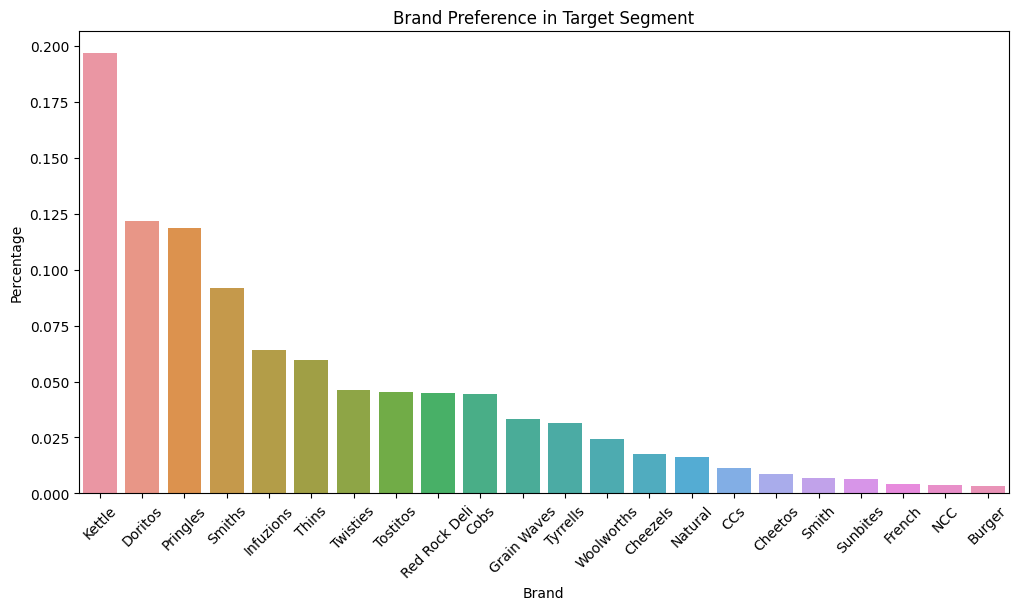

In [22]:
# Brand preference
brand_preference = target_segment['BRAND'].value_counts(normalize=True).reset_index()
brand_preference.columns = ['Brand', 'Percentage']

plt.figure(figsize=(12,6))
sns.barplot(x='Brand', y='Percentage', data=brand_preference)
plt.title('Brand Preference in Target Segment')
plt.xticks(rotation=45)
plt.show()

### Pack Size Analysis

* 175g packs are the most popular size across segments
* Sales distribution across pack sizes suggests preference for medium-sized packages
* Opportunity for package optimization based on segment preferences

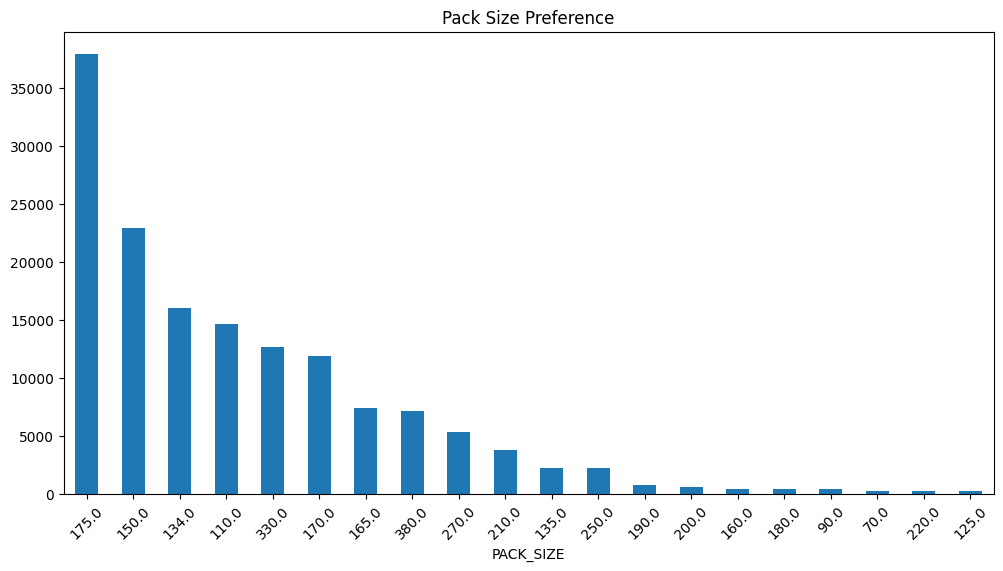

In [23]:
# Pack size preference
pack_preference = target_segment.groupby('PACK_SIZE')['TOT_SALES'].sum().sort_values(ascending=False)


# Plot pack size preference
plt.figure(figsize=(12,6))
pack_preference.plot(kind='bar')
plt.title('Pack Size Preference')
plt.xticks(rotation=45)
plt.show()



**For a detailed graph, please refer to the visualization below.**

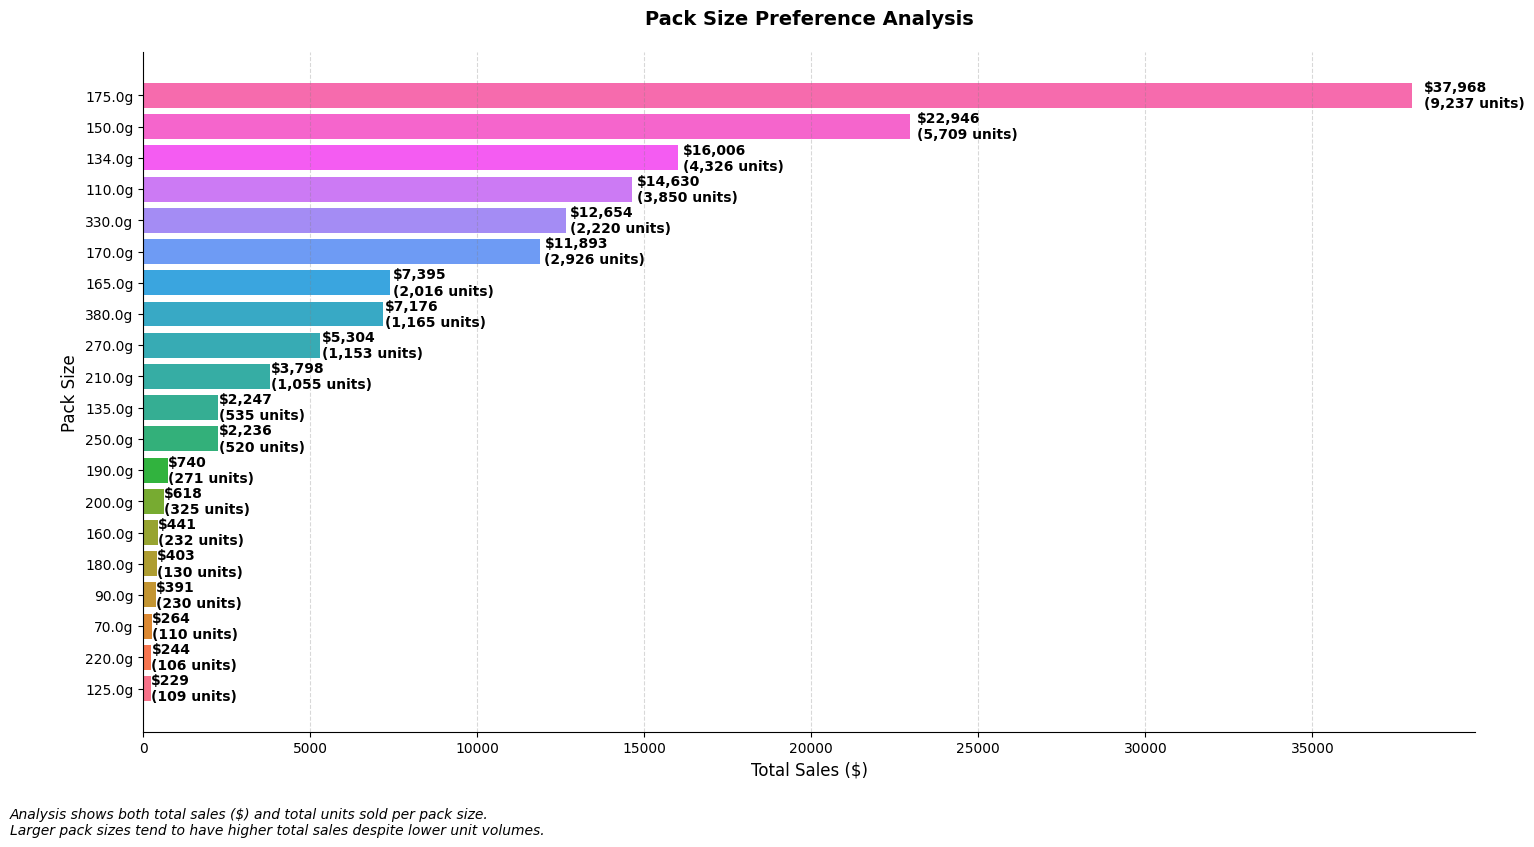

In [24]:

# Calculate pack size preferences with both total sales and unit counts
pack_analysis = target_segment.groupby('PACK_SIZE').agg({
    'TOT_SALES': 'sum',
    'PROD_QTY': 'sum'
}).reset_index()

# Sort by total sales
pack_analysis = pack_analysis.sort_values('TOT_SALES', ascending=True)

# Create figure and axis with larger size and white background
plt.figure(figsize=(15, 8), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# Create horizontal bar chart with a more distinct color palette
colors = sns.color_palette("husl", len(pack_analysis))  # Using HUSL color space for better distinction
bars = plt.barh(pack_analysis['PACK_SIZE'].astype(str) + 'g', 
                pack_analysis['TOT_SALES'],
                color=colors)

# Customize the plot
plt.title('Pack Size Preference Analysis', pad=20, size=14, fontweight='bold', color='black')
plt.xlabel('Total Sales ($)', size=12, color='black')
plt.ylabel('Pack Size', size=12, color='black')

# Add value labels on the bars with black text for better visibility
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + (width * 0.01),  # Slightly offset from the end of the bar
             bar.get_y() + bar.get_height()/2,
             f'${width:,.0f}\n({pack_analysis.iloc[i]["PROD_QTY"]:,.0f} units)',
             ha='left', va='center', fontsize=10, color='black', fontweight='bold')
    
# Add gridlines with better visibility
plt.grid(axis='x', linestyle='--', alpha=0.3, color='gray')

# Style the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(colors='black')
plt.setp(ax.get_xticklabels(), color='black')
plt.setp(ax.get_yticklabels(), color='black')

# Adjust layout
plt.tight_layout()

# Add annotations with black text
plt.text(-0.1, -0.15, 
         'Analysis shows both total sales ($) and total units sold per pack size.\n' + 
         'Larger pack sizes tend to have higher total sales despite lower unit volumes.',
         transform=plt.gca().transAxes, fontsize=10, style='italic', color='black')

# Show the plot
plt.show()


### Statistical Analysis


A t-test was performed to compare pricing between Mainstream and other segments. This indicates a statistically significant difference in price sensitivity between Mainstream and other customer segments.

Statistical Significance
The t-test results (t-statistic: 37.83, p-value: ~0) tell us:
* The price difference is highly significant
* There's virtually no chance this difference is random
* The large t-statistic indicates a substantial effect size

In [25]:
# T-test for price comparison
mainstream_price = merged_data[
    (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream') & 
    (merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]['PRICE_PER_UNIT']
    
other_price = merged_data[
    (merged_data['PREMIUM_CUSTOMER'].isin(['Budget', 'Premium'])) & 
    (merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]['PRICE_PER_UNIT']
    
t_stat, p_value = stats.ttest_ind(mainstream_price, other_price)

In [26]:
print(f"\nT-test Results:")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


T-test Results:
t-statistic: 37.83196107667825
p-value: 2.235645611540966e-309


# Conclusion

**1. Dominant Customer Segments**
   * Mainstream - Young Singles/Couples:

       * Highest total sales contribution

       * Largest customer base

       * Willing to pay ~5% higher prices than Budget/Premium segments (p-value ≈ 0)

   * Mainstream - Retirees:

       * Second-largest sales contribution
  
**2. Purchase Behavior**

  * Families (Older/Young):

      * Buy more units per customer than other groups

      * Prefer mid-sized packs (150g–200g)

  * Premium Customers:

     * Lowest chip consumption, likely due to preference for healthier snacks

**3. Pack Size Preferences**

  * Target Segment (Mainstream Young): Most of sales come from 150g–220g packs.

**4. Brand Affinity**

  * Top brands in target segment: Kettle, Smiths, Doritos, Pringles.




  